In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [2]:
dpath = "data\\pns-data-1024\\"

In [7]:
qpars = pd.read_csv("fit-results\\avoided-crossing-fit-pars.csv")

In [70]:
def g2(pops):
    num = np.sum(np.array([k*(k-1) for k in range(len(pops))])*pops)
    den = (np.sum(np.arange(len(pops))*pops))**2
    return num/den

# N=1 Power Sweep Spectra

In [71]:
delta_curr = np.linspace(20e-6, 0e-6, 21)
q7detune = np.array(qpars[qpars['qubit'] == 7]['a'])*delta_curr

In [72]:
idxs_lowP = np.concatenate([range(4,14), range(51,62)])

In [73]:
lim1 = np.array([
    -0.02, -0.02, -0.017,
    -0.018, -0.021, -0.021,
    -0.021, -0.0203, -0.0179,
    -0.0165, -0.0145, -0.014,
    -0.009, -0.005, -0.005,
    -0.005, -0.004, -0.003,
    0.0, -0.003, -0.002
])
lim2 = np.array([
    0.01, 0.011, 0.011,
    0.011, 0.011, 0.011,
    0.011, 0.011, 0.01,
    0.01, 0.01, 0.01,
    0.01, 0.01, 0.005,
    0.004, 0.006, 0.007,
    0.007, 0.005, 0.007
])
cutoff = np.array([
    -7, -7, -6,
    -6, -6, -1,
    -1, -1, -2,
    -1, -1, 0,
    0, 0, -1,
    -1, -1, -1,
    -1, -1, -1
])
distance = np.array([
    40, 30, 30,
    30, 30, 30,
    30, 30, 30,
    30, 30, 25,
    25, 25, 25,
    22, 21, 20,
    18, 17, 16
])
width = np.array([
    6, 6, 6,
    6, 6, 6,
    6, 6, 6,
    6, 6, 6,
    6, 6, 6,
    6, 6, 6,
    5, 5, 4
])

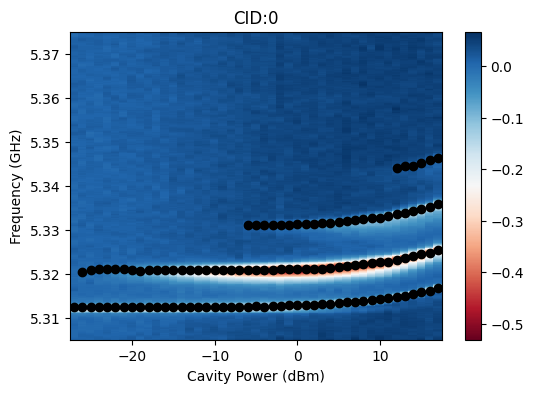

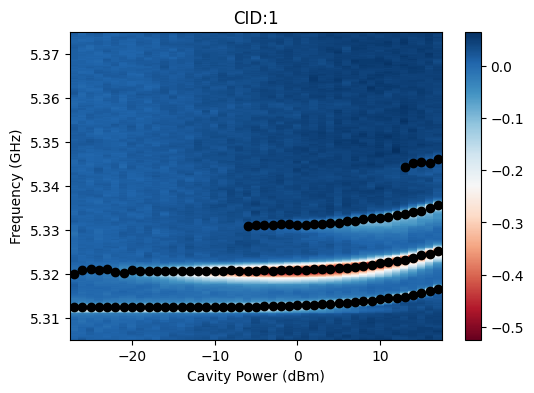

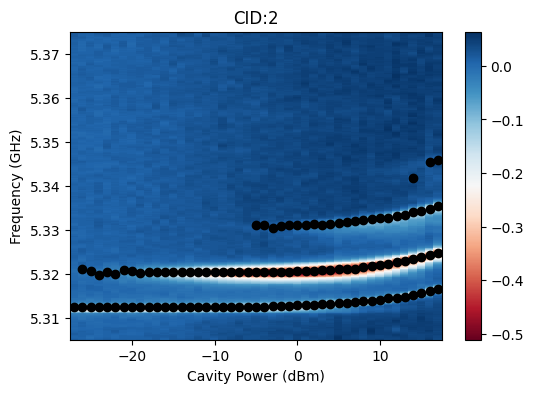

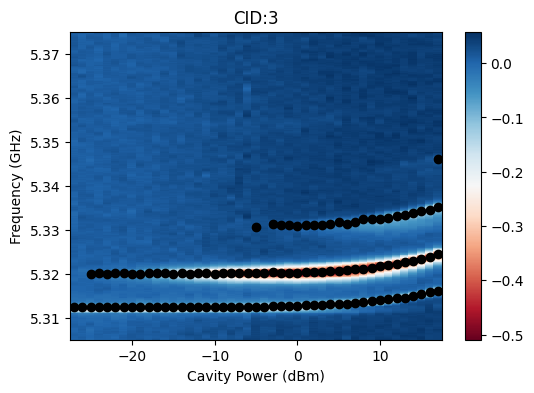

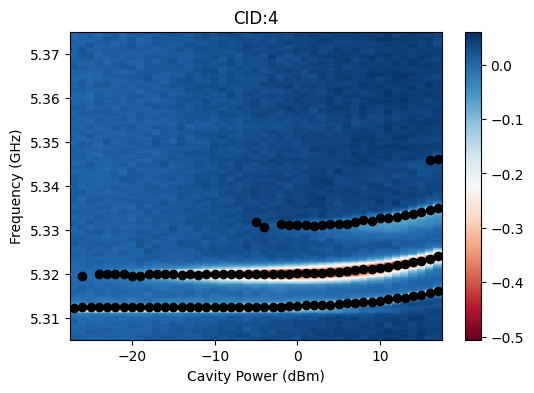

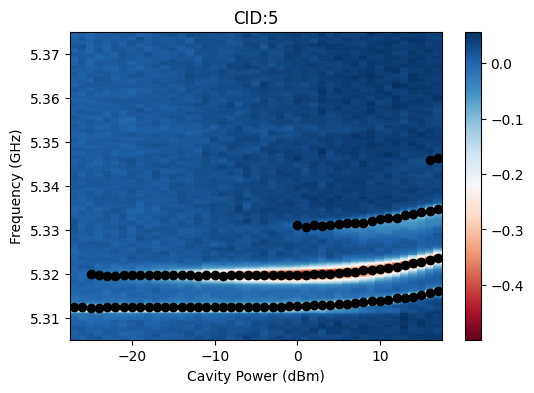

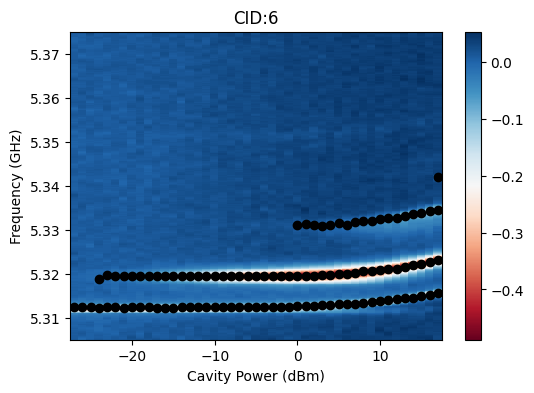

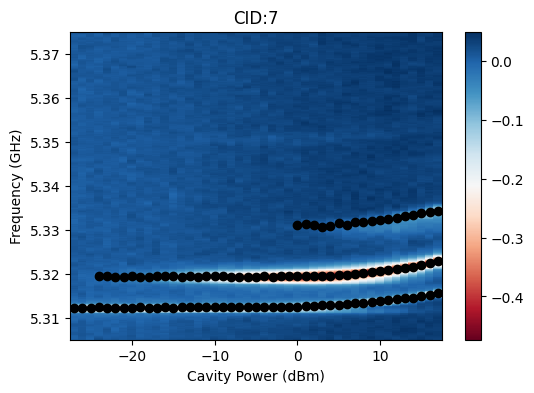

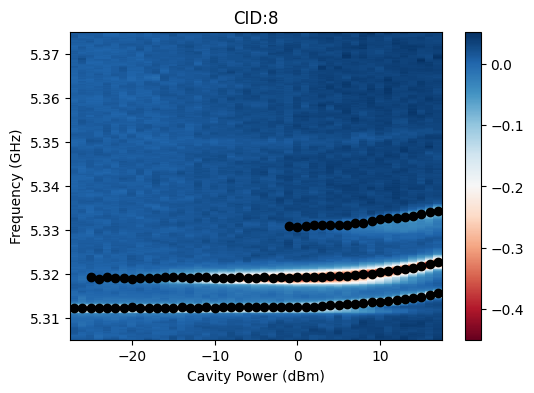

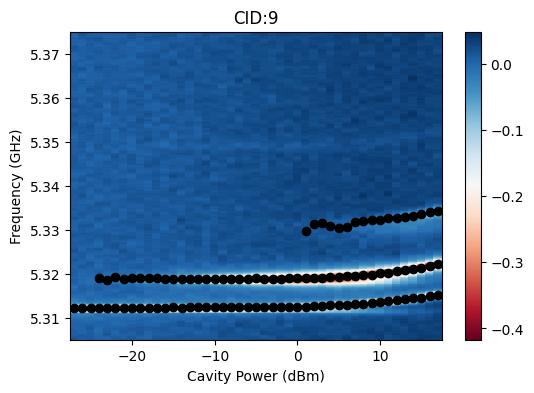

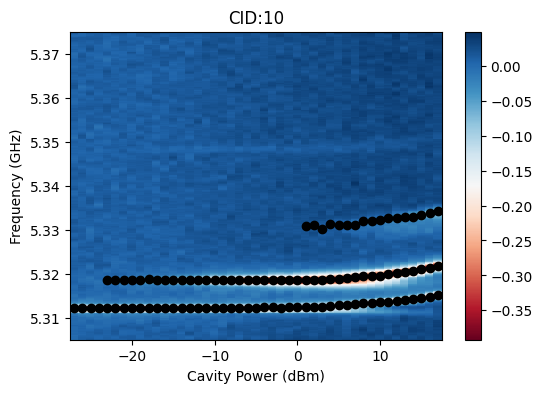

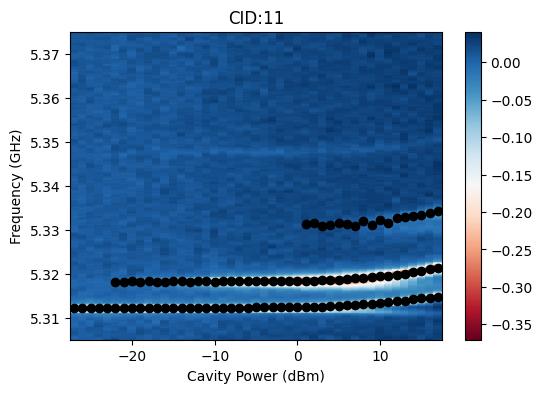

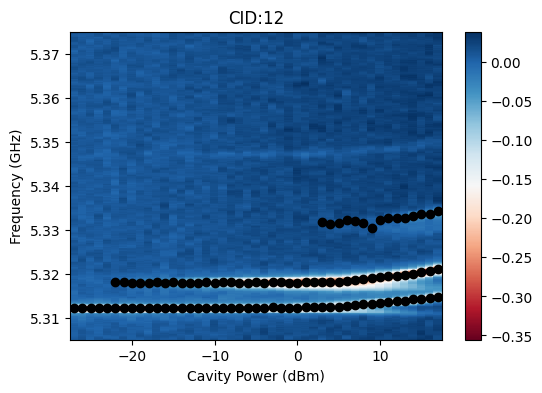

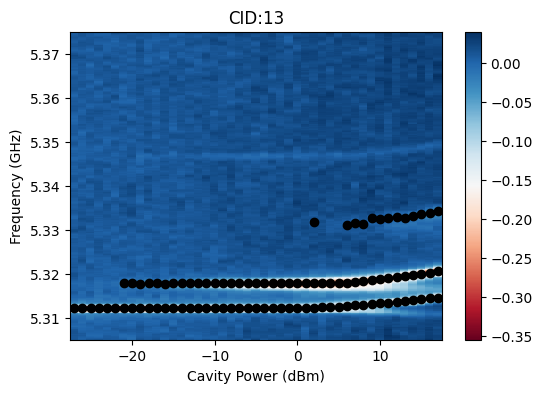

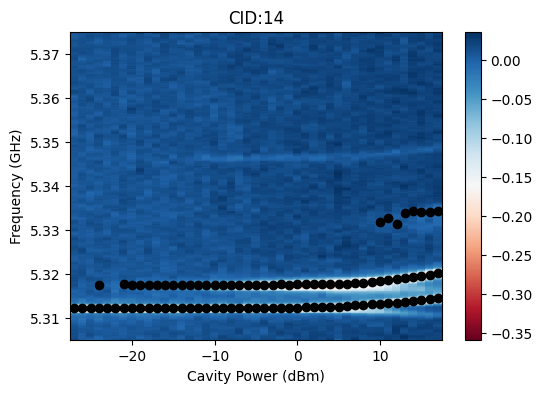

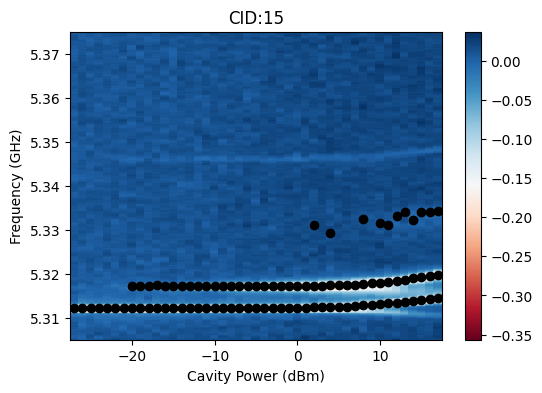

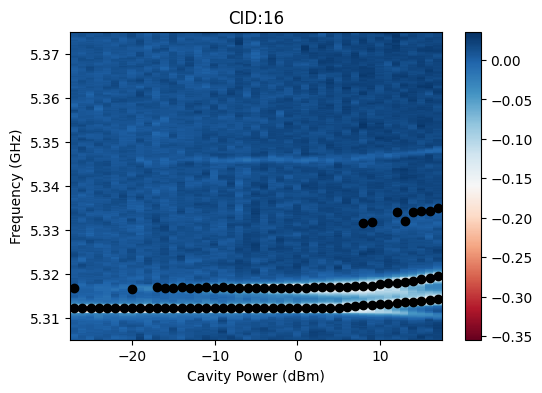

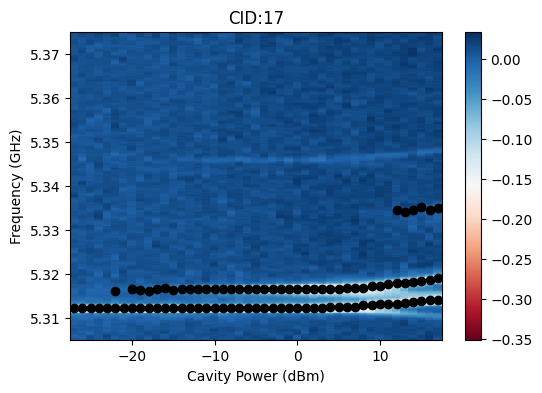

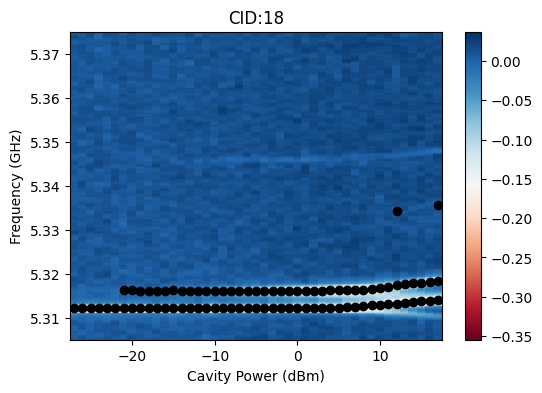

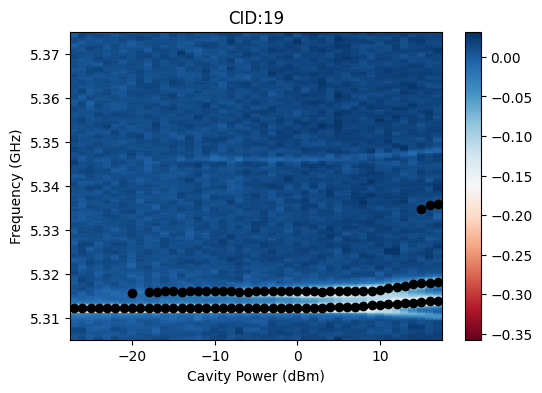

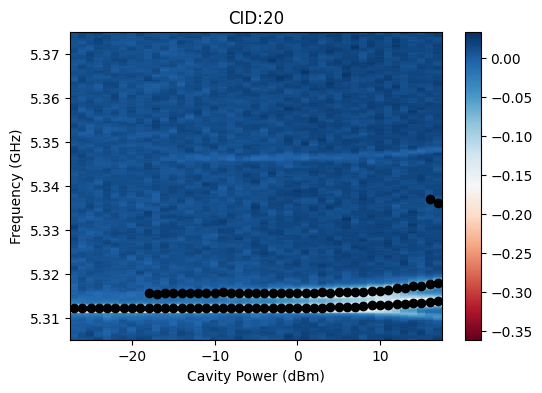

In [74]:
dataH = np.zeros([21, 45, 6])
fs_full = np.zeros([21, 45, 6])
for cid, counter in enumerate(idxs_lowP):
    if True:
        df = pd.read_csv(dpath + f'Q{4}-pns-power-{counter}.csv')

        freqs = np.unique(df['frequency'])
        buspows = np.unique(df['buspower'])
        phase = np.array(df['phase']).reshape([len(buspows), len(freqs)])
        phase = phase.transpose() - np.mean(phase[-50:, :], axis=1)
        phase = np.unwrap(phase)
        phase = scipy.signal.savgol_filter(phase, 11, 3, axis=0)

        fs = np.zeros([len(buspows), 6])
        hs = np.zeros([len(buspows), 6])
        for i in range(len(buspows)):
            y = -phase[:,i]
            if buspows[i] > cutoff[cid]:
                limit = lim1[cid]
            if buspows[i] <= cutoff[cid]:
                limit = lim2[cid]
            pks = scipy.signal.find_peaks(y, height=limit, width=width[cid], prominence=limit, distance=distance[cid])
            proms = np.zeros(len(pks[0]))
            for k in range(len(proms)):
                proms[k] = pks[1]['prominences'][k]
            if len(pks[0]) > 1:
                if pks[1]['left_bases'][0] == pks[1]['left_bases'][1]:
                    pflips = [proms[0], proms[1]]
                    proms[0] = pflips[1]
                    proms[1] = pflips[0]
            counter = 0
            for j in range(np.min([6, len(pks[0])])):
                if cid < 6:
                    if freqs[pks[0][j]] > 5.311e9 and freqs[pks[0][j]] < 5.360e9:
                        fs[i, counter] = freqs[pks[0][j]]
                        hs[i, counter] = proms[j]
                        counter += 1
                else:
                    if freqs[pks[0][j]] > 5.311e9 and freqs[pks[0][j]] < 5.345e9:
                        fs[i, counter] = freqs[pks[0][j]]
                        hs[i, counter] = proms[j]
                        counter += 1
            hs[i, :] = (hs[i, :] - np.min(hs[i, :]))/np.sum(hs[i, :])    
        
        fs_full[cid, :, :] = fs
        dataH[cid, :, :] = hs
        
        plt.figure(figsize=(6,4))
        plt.pcolor(buspows, freqs/1e9, phase, cmap='RdBu')
        plt.plot(buspows, fs/1e9, 'o', color='k')
        plt.colorbar()
        plt.ylim([np.min(freqs/1e9), None])
        plt.title(f'CID:{cid}')
        plt.ylabel('Frequency (GHz)')
        plt.xlabel('Cavity Power (dBm)')
        plt.show()

In [75]:
dataH.shape, fs_full.shape

((21, 45, 6), (21, 45, 6))

In [31]:
ncol = []
hscol = []
deltcol = []
fscol = []
powcol = []

In [32]:
for i, power in enumerate(buspows):
    for j, detune in enumerate(q7detune):
        for n in range(4):
            ncol.append(n)
            hscol.append(dataH[j, i, n])
            deltcol.append(detune)
            fscol.append(fs_full[j, i, n])
            powcol.append(power)

In [33]:
df_dict = {
    'n': ncol,
    'pop': hscol,
    'detuning': deltcol,
    'freq': fscol,
    'power': powcol
}
df = pd.DataFrame(df_dict)

In [35]:
# df.to_csv("fit-results\\N1-photon-pops.csv")

In [76]:
g2s = np.zeros([len(q7detune), len(buspows)])
for j in range(len(q7detune)):
    for i in range(len(buspows)):
        if j < 25:
            g2s[j, i] = g2(dataH[j,i,:4])
        else:
            g2s[j, i] = g2(dataH[j,i,:3])

C:\Users\Instrument\AppData\Local\Temp\ipykernel_10324\4321067.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return num/den


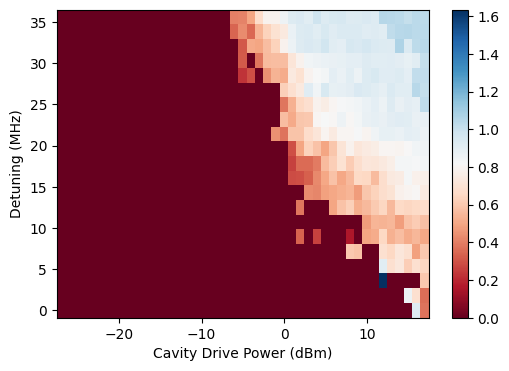

In [79]:
plt.figure(figsize=(6,4))
g2s[np.isnan(g2s)] = 0
plt.pcolor(buspows, q7detune/1e6, g2s, cmap='RdBu')
plt.xlabel('Cavity Drive Power (dBm)')
plt.ylabel('Detuning (MHz)')
plt.colorbar()
plt.show()

In [80]:
g2_col = []
det_col = []
amp_col = []
for did, det in enumerate(q7detune):
    for aid, amp in enumerate(buspows):
        g2_col.append(g2s[did, aid])
        det_col.append(det)
        amp_col.append(amp)
df_dict = {
    'g2': g2_col,
    'detuning': det_col,
    'power': amp_col
}
df = pd.DataFrame(df_dict)
# df.to_csv("fit-results\\g2-N1-exp.csv")

# N=2 Power Sweep Spectra

In [81]:
idxs_lowP = np.array(range(65,86))
idxs_highP = np.array(range(87,108))

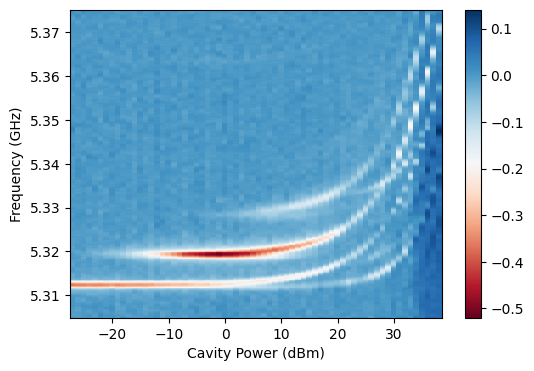

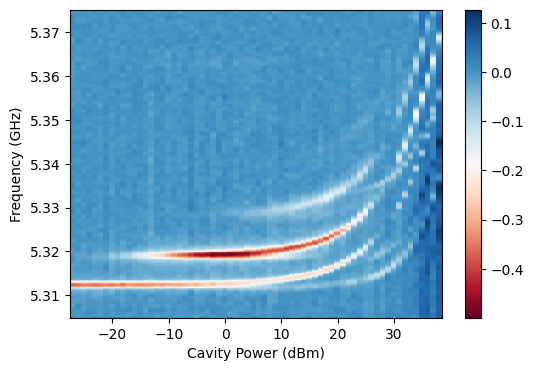

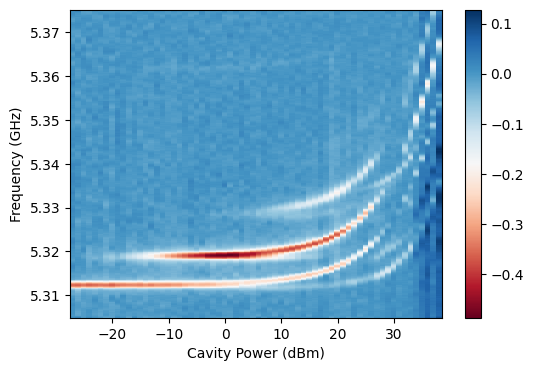

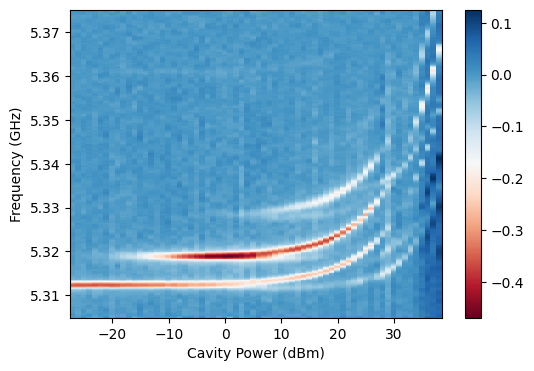

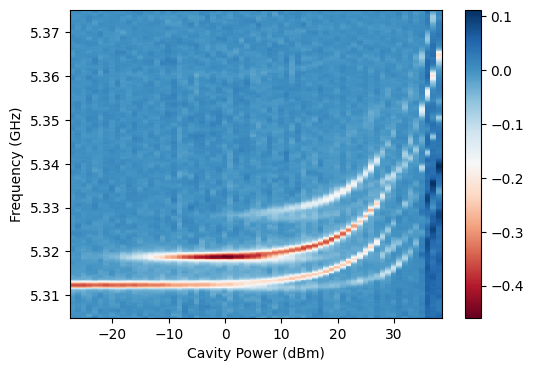

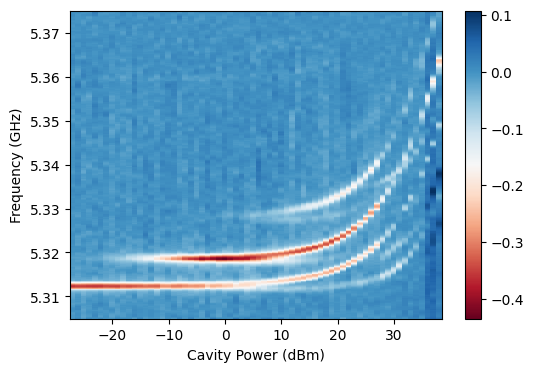

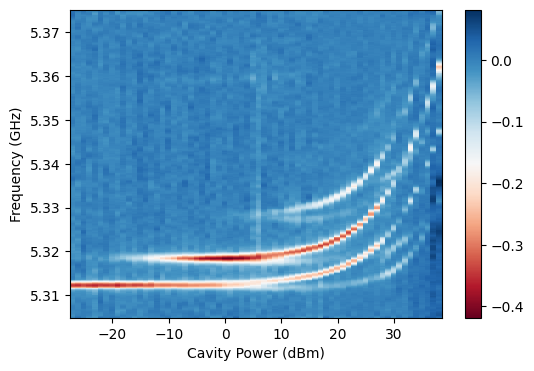

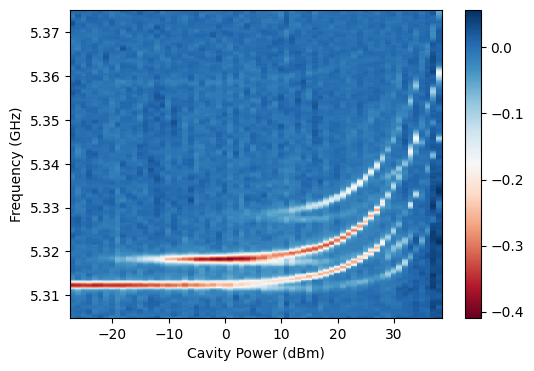

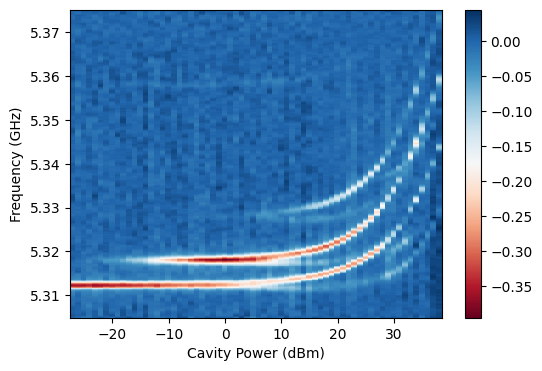

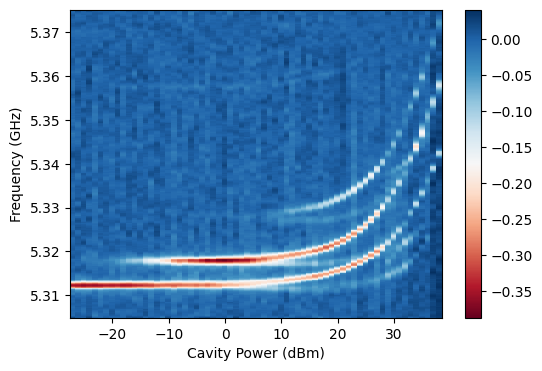

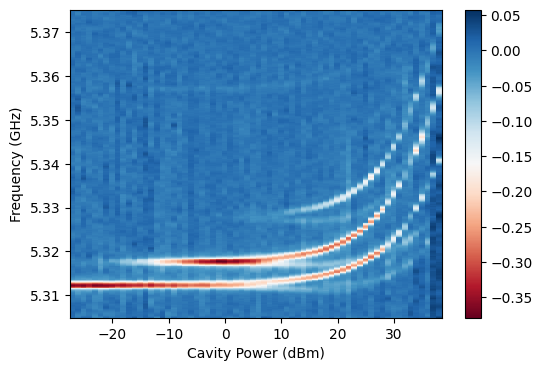

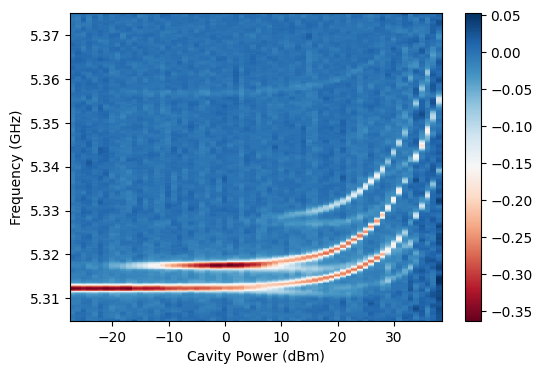

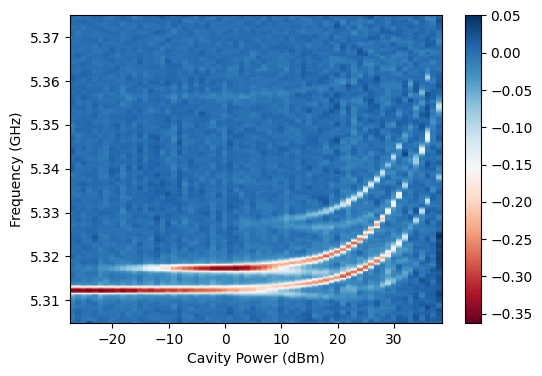

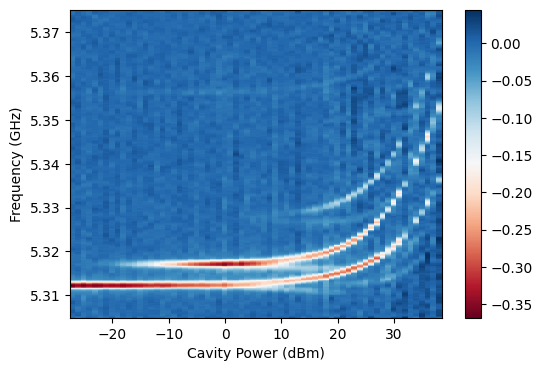

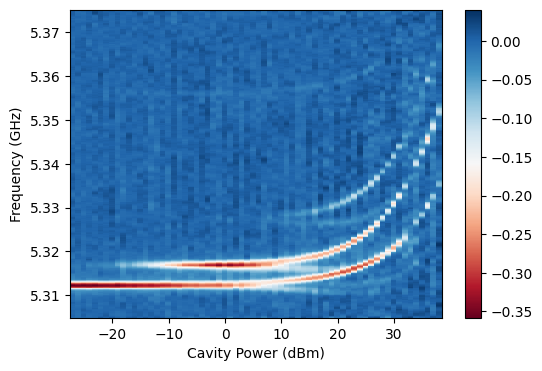

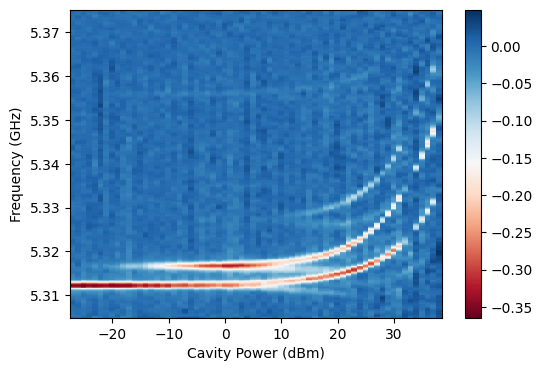

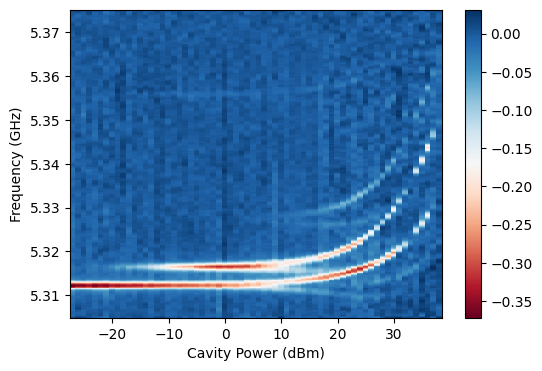

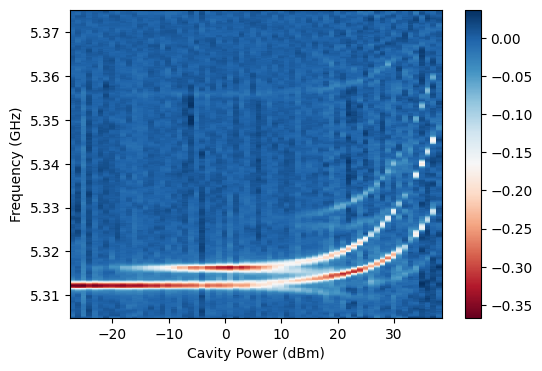

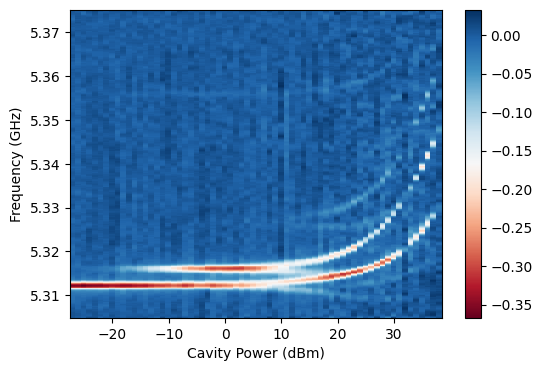

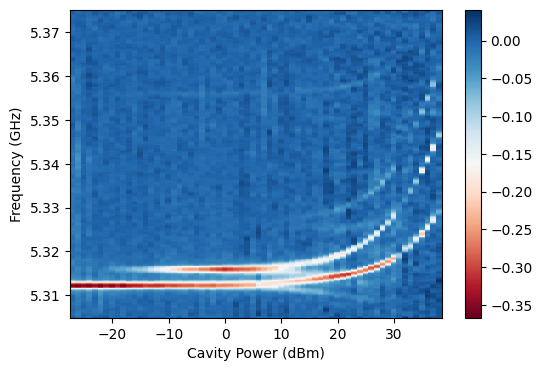

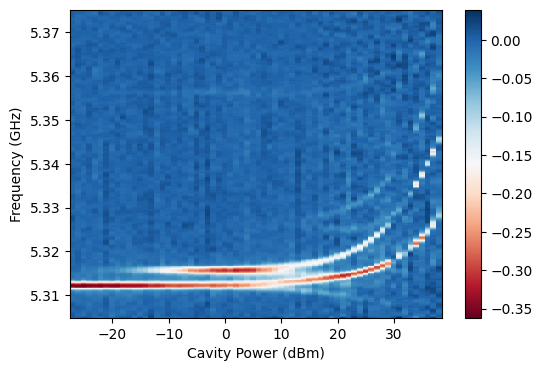

In [82]:
for counterL, counterH in zip(idxs_lowP, idxs_highP):
    df = pd.read_csv(dpath + f'Q{4}-pns-power-{counterL}.csv')
    df2 = pd.read_csv(dpath + f'Q{4}-pns-power-{counterH}.csv')

    freqs = np.unique(df['frequency'])
    buspows = np.unique(df['buspower'])
    buspows2 = np.unique(df2['buspower'])
    phase = np.array(df['phase']).reshape([len(buspows), len(freqs)])
    phase2 = np.array(df2['phase']).reshape([len(buspows2), len(freqs)])
    buspows2 = buspows2[-21:] + 21
    phase2 = phase2[-21:,:]
    
    phase = np.concatenate([phase, phase2])
    buspows = np.concatenate([buspows, buspows2])
    
    plt.figure(figsize=(6,4))
    phase = phase.transpose() - np.mean(phase[:, -50:], axis=1)
    phase = np.unwrap(phase)
    phase = scipy.signal.savgol_filter(phase, 11, 3, axis=0)
    plt.pcolor(buspows, freqs/1e9, phase, cmap='RdBu')
    plt.colorbar()
    plt.ylabel('Frequency (GHz)')
    plt.xlabel('Cavity Power (dBm)')
    plt.show()

In [83]:
lim1 = np.array([
    -0.007, -0.006, -0.006,
    -0.003, -0.001, 0.005,
    0.011, 0.011, 0.005,
    0.012, 0.000, 0.000,
    0.000, 0.006, 0.003,
    0.008, 0.004, 0.006,
    0.008, 0.008, 0.006
])
lim2 = np.array([
    0.010, 0.010, 0.015,
    0.015, 0.015, 0.0135,
    0.0135, 0.0185, 0.0155,
    0.0155, 0.012, 0.008,
    0.007, 0.008, 0.011,
    0.014, 0.020, 0.011,
    0.008, 0.022, 0.008
])
cutoff = np.array([
    -4, -4, -4,
    -4, -4, -4,
    -4, -4, -4,
    -4, -4, -4,
    -4, -4, -4,
    -4, -4, -4,
    -4, -4, -4
])
distance = np.array([
    22, 22, 22,
    22, 25, 25,
    25, 28, 28,
    26, 25, 25,
    23, 23, 21,
    21, 19, 19,
    18, 17, 16
])
width = np.array([
    4, 4, 4,
    4, 4, 4,
    4, 4, 4,
    4, 4, 4,
    4, 4, 4,
    5, 5, 5,
    5, 4, 4
])

In [84]:
detuning = np.linspace(30e6, 0, 21)

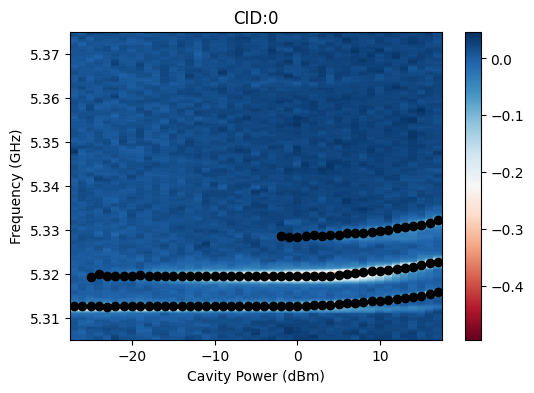

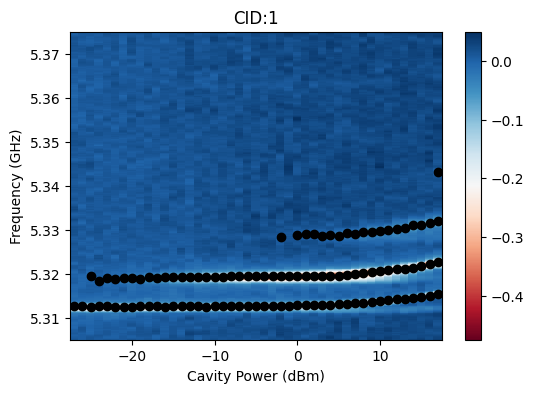

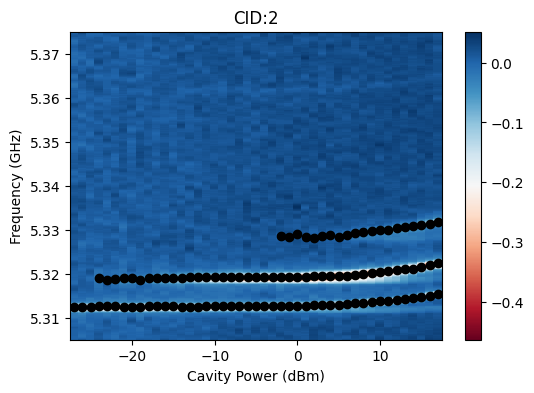

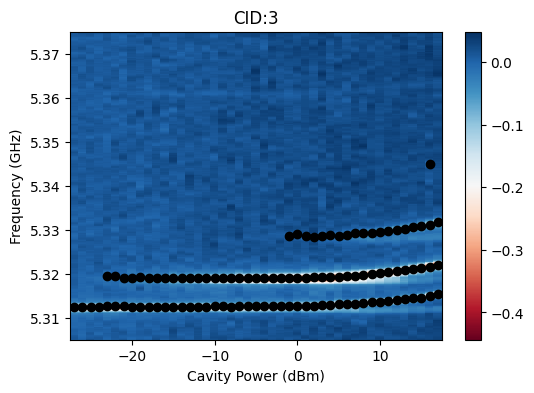

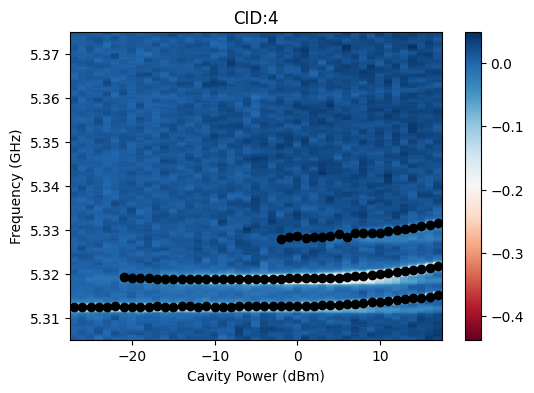

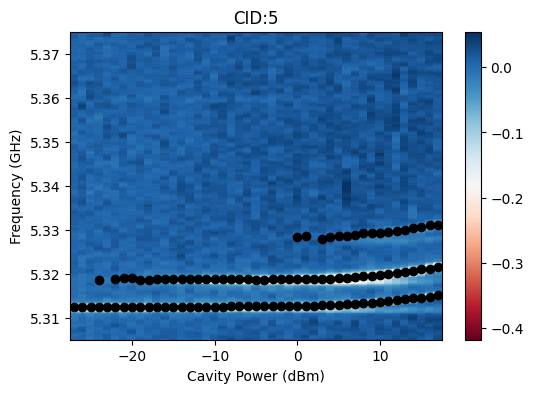

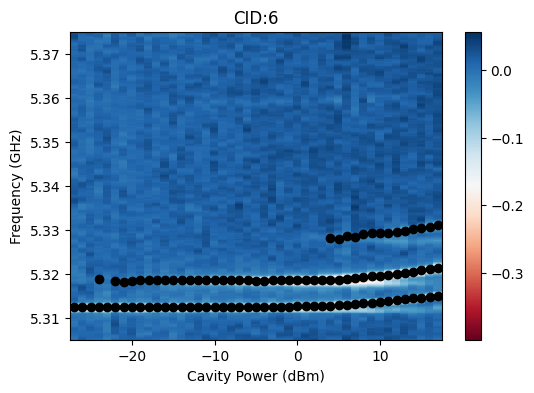

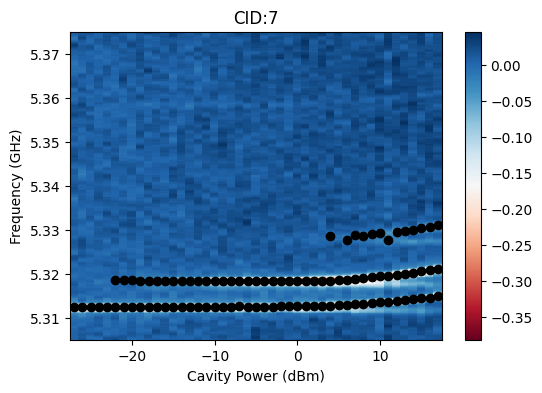

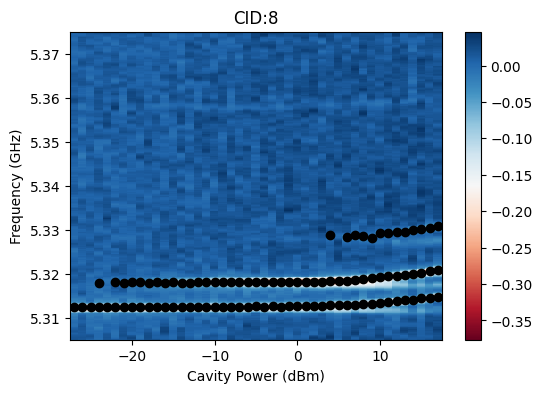

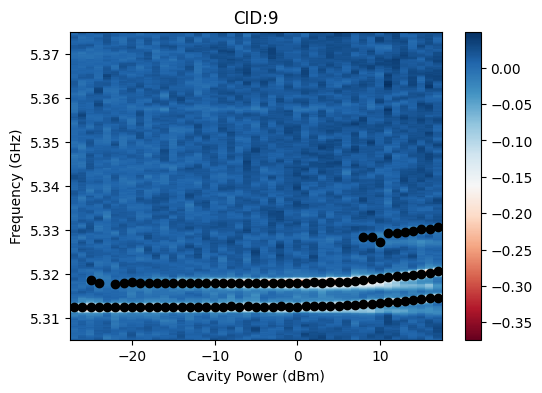

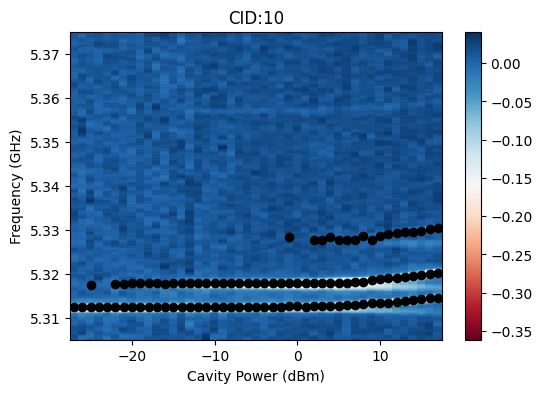

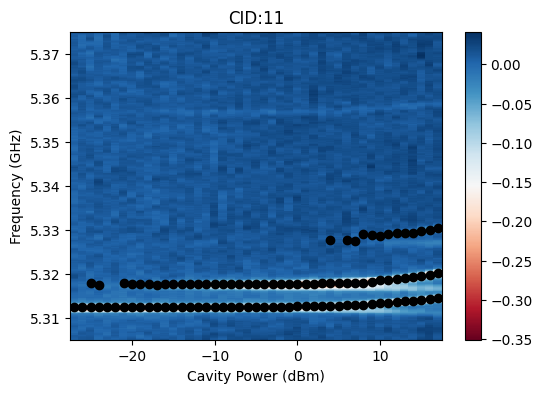

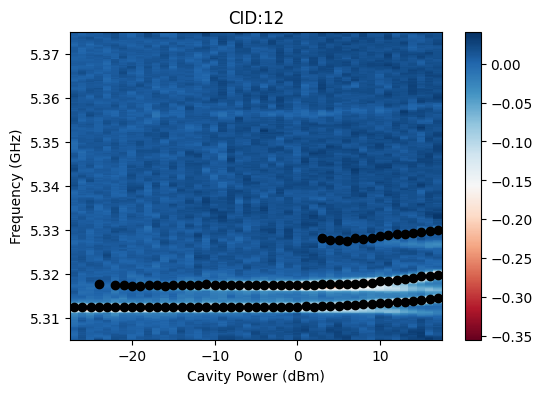

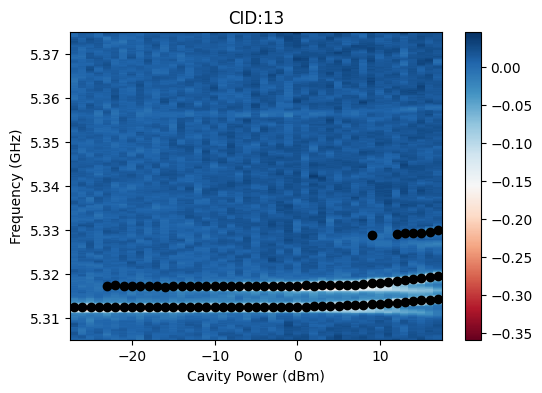

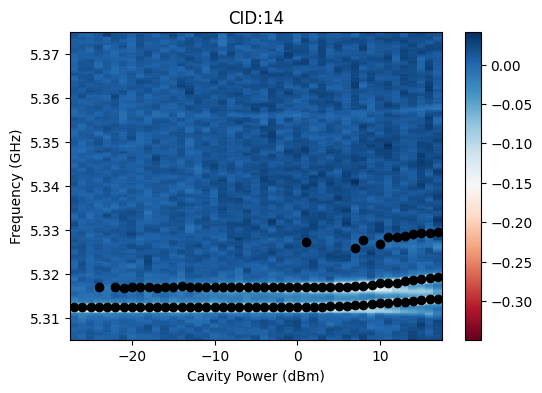

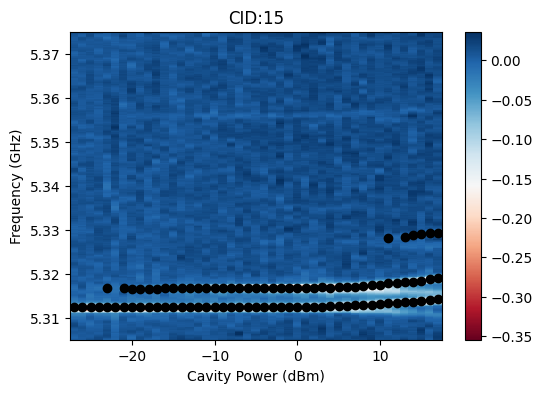

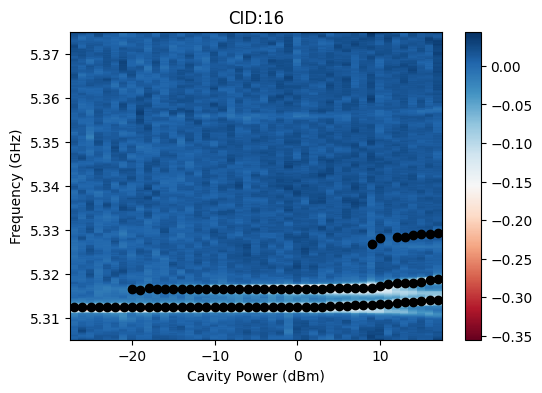

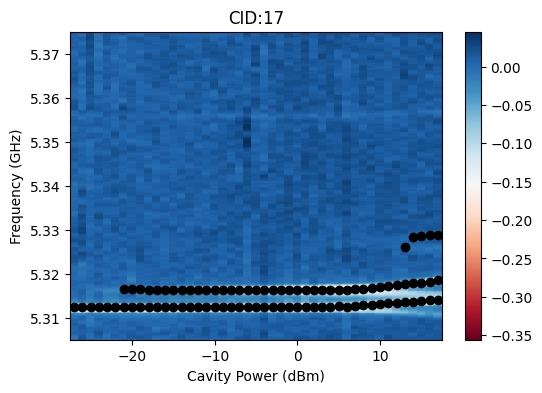

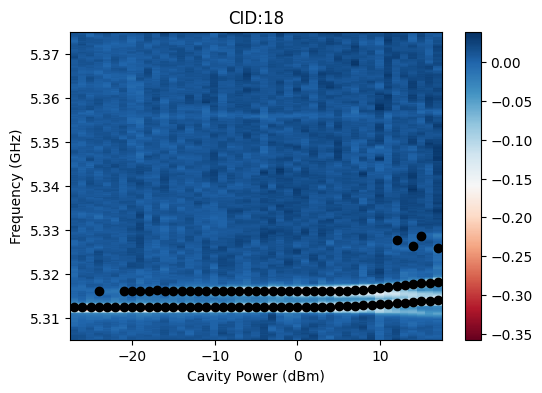

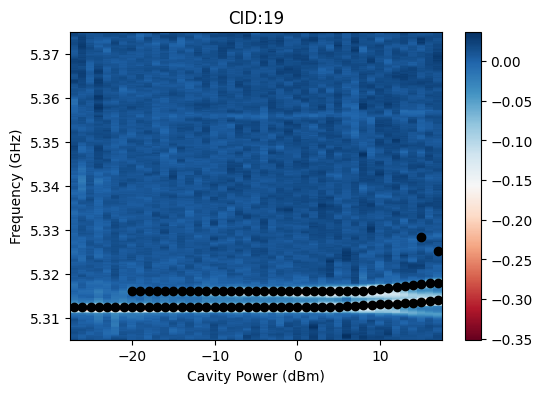

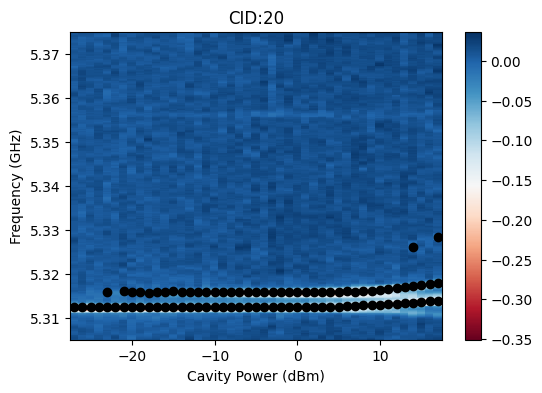

In [85]:
dataH = np.zeros([21, 45, 6])
fs_full = np.zeros([21, 45, 6])
for cid, counter in enumerate(idxs_lowP):
    if True:
        df = pd.read_csv(dpath + f'Q{4}-pns-power-{counter}.csv')

        freqs = np.unique(df['frequency'])
        buspows = np.unique(df['buspower'])
        phase = np.array(df['phase']).reshape([len(buspows), len(freqs)])
        phase = phase.transpose() - np.mean(phase[-50:, :], axis=1)
        phase = np.unwrap(phase)
        phase = scipy.signal.savgol_filter(phase, 11, 3, axis=0)

        fs = np.zeros([len(buspows), 6])
        hs = np.zeros([len(buspows), 6])
        for i in range(len(buspows)):
            y = -phase[:,i]
            if buspows[i] > cutoff[cid]:    
                limit = lim1[cid]
            if buspows[i] <= cutoff[cid]:    
                limit = lim2[cid]
            pks = scipy.signal.find_peaks(y, height=limit, width=width[cid], prominence=limit, distance=distance[cid])
            proms = np.zeros(len(pks[0]))
            for k in range(len(proms)):
                proms[k] = pks[1]['prominences'][k]
            counter = 0
            if len(pks[0]) > 1:
                if pks[1]['left_bases'][0] == pks[1]['left_bases'][1]:
                    pflips = [proms[0], proms[1]]
                    proms[0] = pflips[1]
                    proms[1] = pflips[0]
            for j in range(np.min([6, len(pks[0])])):
                if freqs[pks[0][j]] > 5.311e9 and freqs[pks[0][j]] < 5.350e9:
                    fs[i, counter] = freqs[pks[0][j]]
                    hs[i, counter] = proms[j]
                    counter += 1
            hs[i, :] = (hs[i, :] - np.min(hs[i, :]))/np.sum(hs[i, :])    
        
        dataH[cid, :, :] = hs
        fs_full[cid, :, :] = fs
        plt.figure(figsize=(6,4))
        plt.pcolor(buspows, freqs/1e9, phase, cmap='RdBu')
        plt.plot(buspows, fs/1e9, 'o', color='k')
        plt.colorbar()
        plt.ylim([np.min(freqs/1e9), None])
        plt.title(f'CID:{cid}')
        plt.ylabel('Frequency (GHz)')
        plt.xlabel('Cavity Power (dBm)')
        plt.show()

In [86]:
dataH.shape, fs_full.shape

((21, 45, 6), (21, 45, 6))

In [57]:
ncol = []
hscol = []
deltcol = []
fscol = []
powcol = []

In [58]:
for i, power in enumerate(buspows):
    for j, detune in enumerate(detuning):
        for n in range(4):
            ncol.append(n)
            hscol.append(dataH[j, i, n])
            deltcol.append(detune)
            fscol.append(fs_full[j, i, n])
            powcol.append(power)

In [59]:
df_dict = {
    'n': ncol,
    'pop': hscol,
    'detuning': deltcol,
    'freq': fscol,
    'power': powcol
}
df = pd.DataFrame(df_dict)

In [60]:
# df.to_csv("fit-results\\N2-photon-pops.csv")

In [87]:
g2s = np.zeros([len(detuning), len(buspows)])
for j in range(len(detuning)):
    for i in range(len(buspows)):
        if j < 25:
            g2s[j, i] = g2(dataH[j,i,:4])
        else:
            g2s[j, i] = g2(dataH[j,i,:3])

C:\Users\Instrument\AppData\Local\Temp\ipykernel_10324\4321067.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return num/den


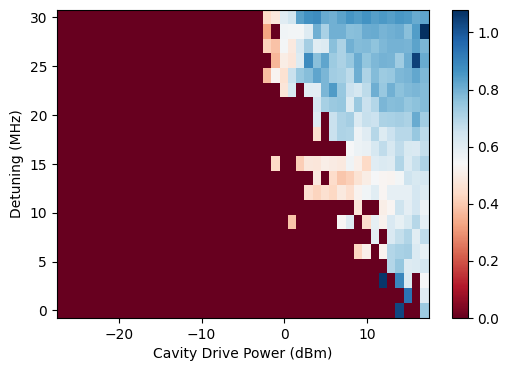

In [88]:
plt.figure(figsize=(6,4))
g2s[np.isnan(g2s)] = 0
plt.pcolor(buspows, detuning/1e6, g2s, cmap='RdBu')
plt.xlabel('Cavity Drive Power (dBm)')
plt.ylabel('Detuning (MHz)')
plt.colorbar()
plt.show()

In [89]:
g2_col = []
det_col = []
amp_col = []
for did, det in enumerate(detuning):
    for aid, amp in enumerate(buspows):
        g2_col.append(g2s[did, aid])
        det_col.append(det)
        amp_col.append(amp)
df_dict = {
    'g2': g2_col,
    'detuning': det_col,
    'power': amp_col
}
df = pd.DataFrame(df_dict)
# df.to_csv("fit-results\\g2-N2-exp.csv")

# N=3 Power Sweep Spectra

In [90]:
idxs_lowP = np.array(range(109,130))
idxs_highP = np.array(range(131,152))

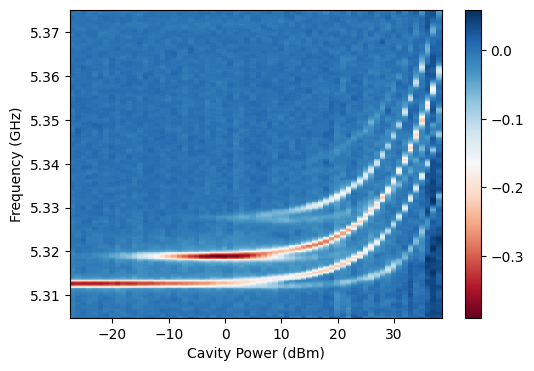

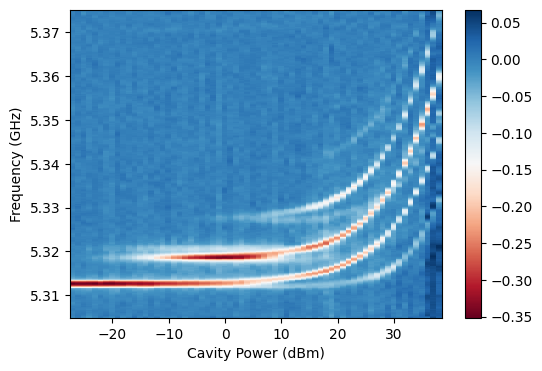

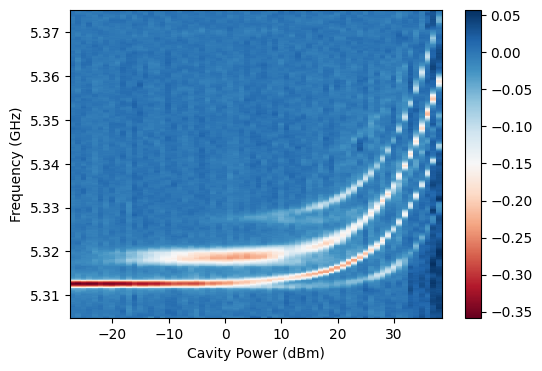

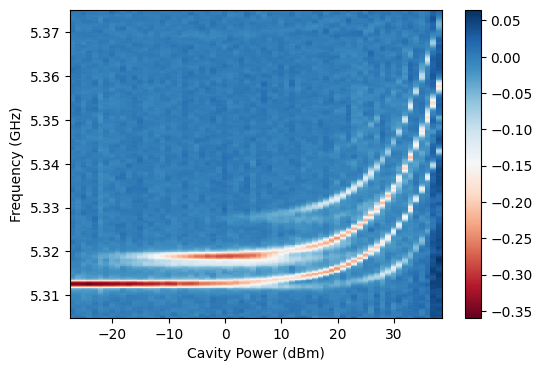

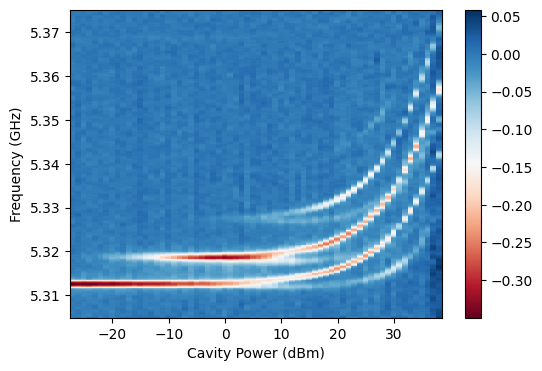

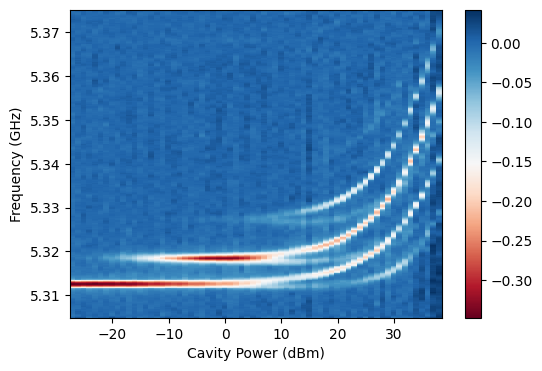

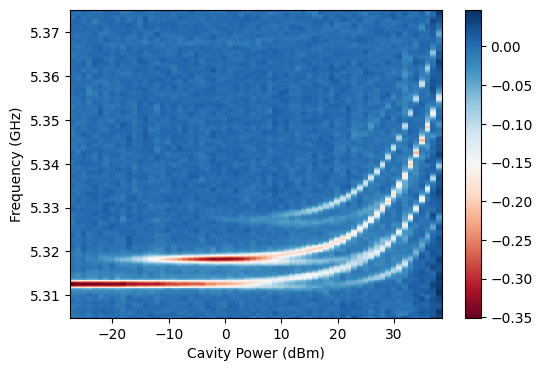

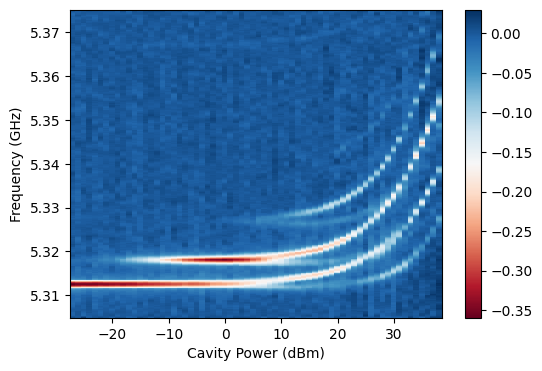

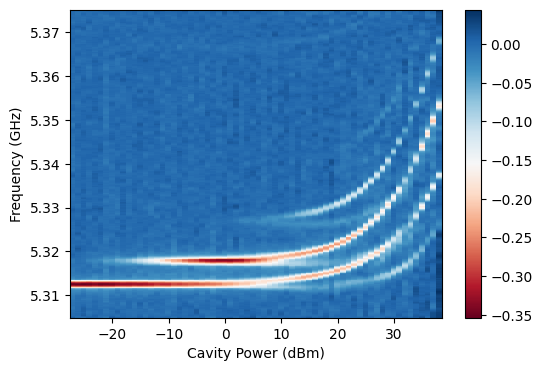

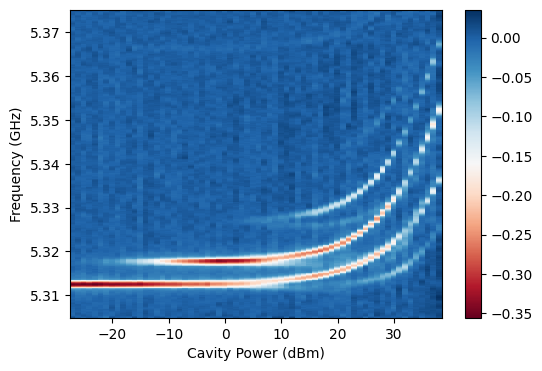

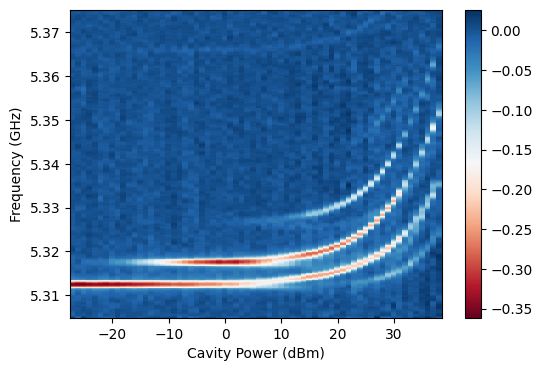

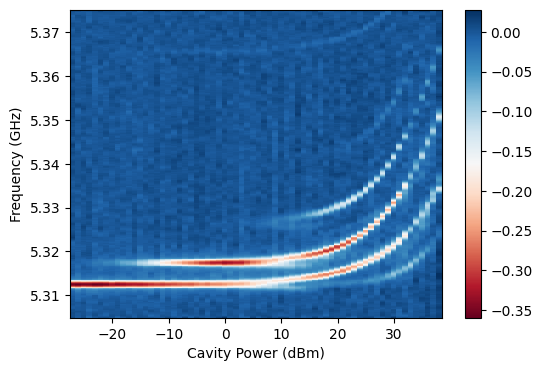

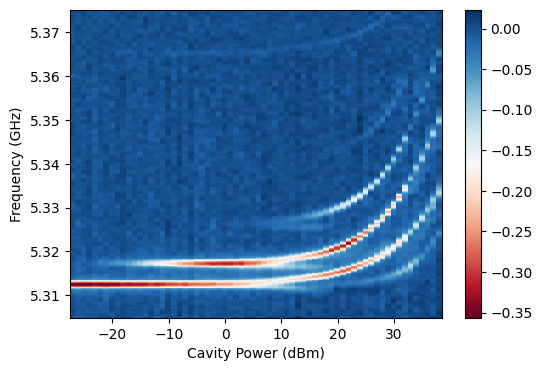

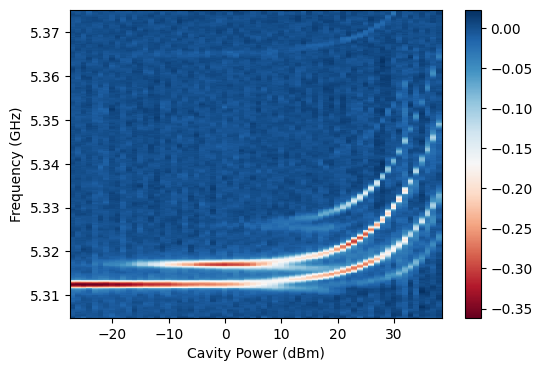

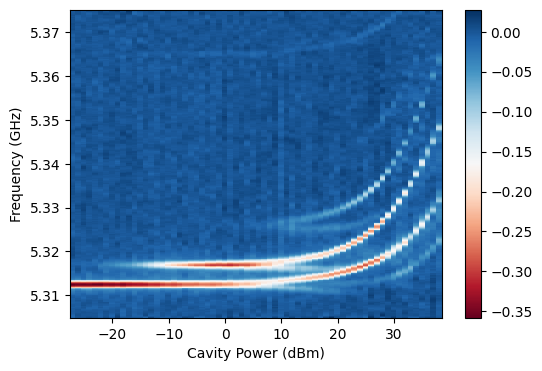

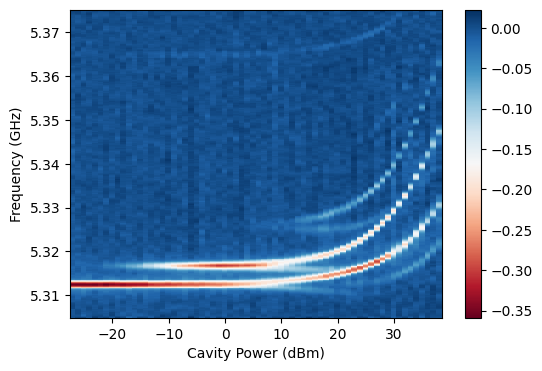

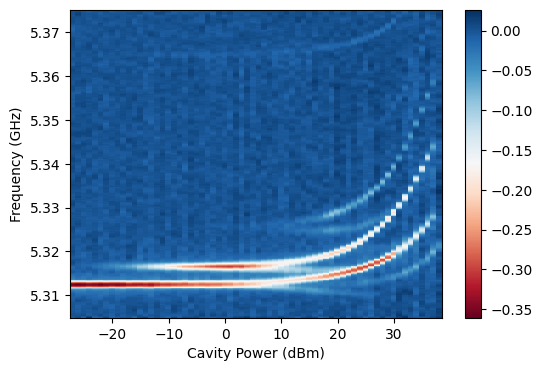

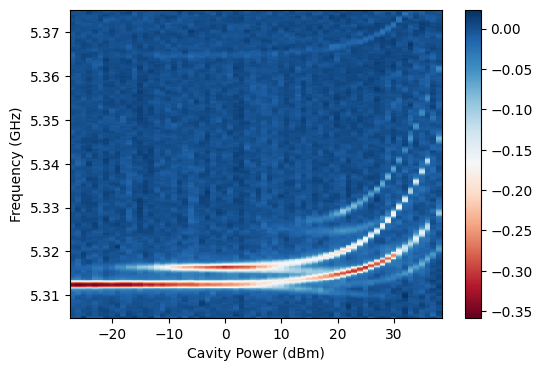

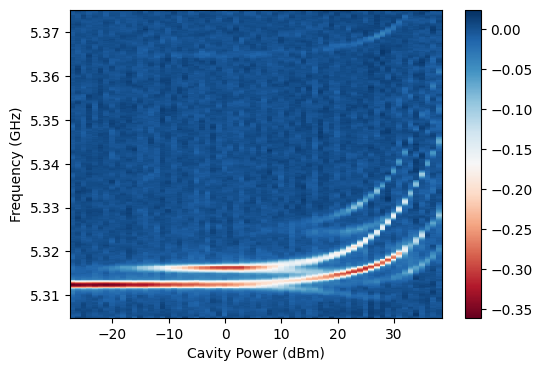

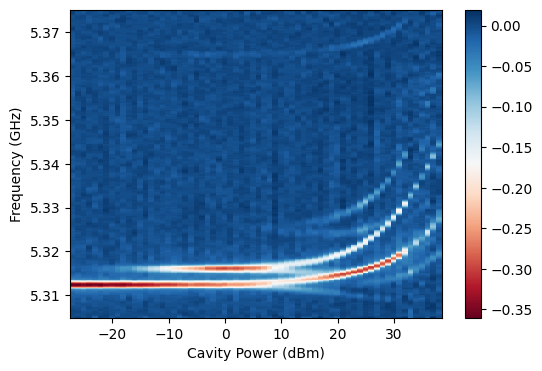

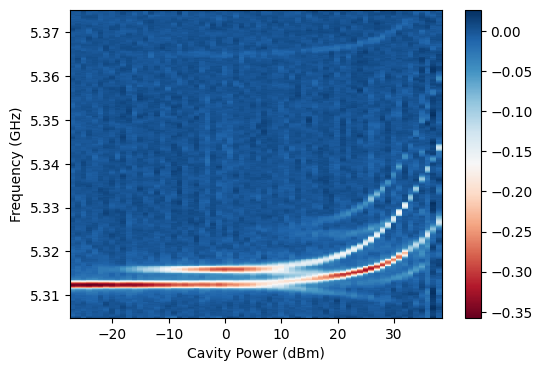

In [91]:
for counterL, counterH in zip(idxs_lowP, idxs_highP):
    df = pd.read_csv(dpath + f'Q{4}-pns-power-{counterL}.csv')
    df2 = pd.read_csv(dpath + f'Q{4}-pns-power-{counterH}.csv')

    freqs = np.unique(df['frequency'])
    buspows = np.unique(df['buspower'])
    buspows2 = np.unique(df2['buspower'])
    phase = np.array(df['phase']).reshape([len(buspows), len(freqs)])
    phase2 = np.array(df2['phase']).reshape([len(buspows2), len(freqs)])
    buspows2 = buspows2[-21:] + 21
    phase2 = phase2[-21:,:]
    
    phase = np.concatenate([phase, phase2])
    buspows = np.concatenate([buspows, buspows2])
    
    plt.figure(figsize=(6,4))
    phase = phase.transpose() - np.mean(phase[:, -50:], axis=1)
    phase = np.unwrap(phase)
    phase = scipy.signal.savgol_filter(phase, 11, 3, axis=0)
    plt.pcolor(buspows, freqs/1e9, phase, cmap='RdBu')
    plt.colorbar()
    plt.ylabel('Frequency (GHz)')
    plt.xlabel('Cavity Power (dBm)')
    plt.show()

In [92]:
lim1 = np.array([
    -0.004, -0.002, -0.001,
    -0.001, 0.001, 0.003,
    0.000, -0.001, 0.001,
    -0.001, 0.000, -0.001,
    0.003, 0.002, 0.003,
    0.002, 0.001, 0.003,
    0.003, 0.004, 0.004,
])
lim2 = np.array([
    0.004, 0.005, 0.005,
    0.004, 0.004, 0.008,
    0.012, 0.0055, 0.005,
    0.008, 0.008, 0.009,
    0.009, 0.004, 0.005,
    0.006, 0.007, 0.006,
    0.004, 0.007, 0.006,
])
cutoff = np.array([
    -10, -10, -10,
    -10, -10, -10,
    -10, -10, -10,
    -10, -10, -10,
    -10, -10, -10,
    -10, -10, -10,
    -10, -5, -5,
])
distance = np.array([
    28, 28, 26,
    26, 26, 26,
    26, 26, 25,
    25, 24, 24,
    22, 21, 20,
    20, 19, 18,
    17, 17, 17,
])
width = np.array([
    4, 4, 4,
    4, 4, 4,
    4, 4, 4,
    4, 4, 4,
    4, 4, 4,
    4, 4, 4,
    4, 4, 4
])

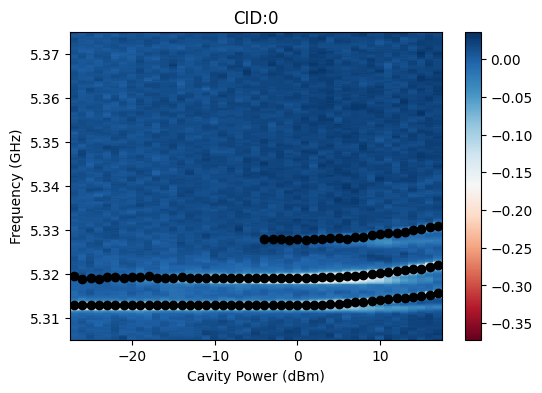

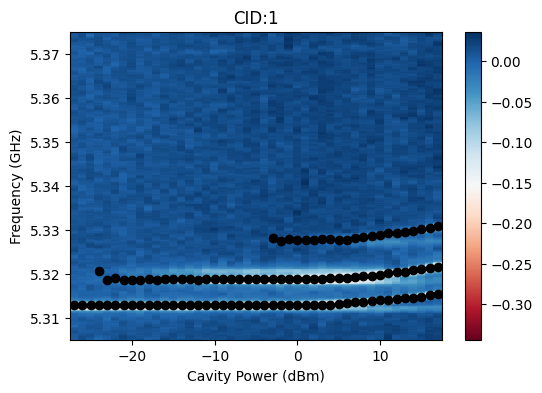

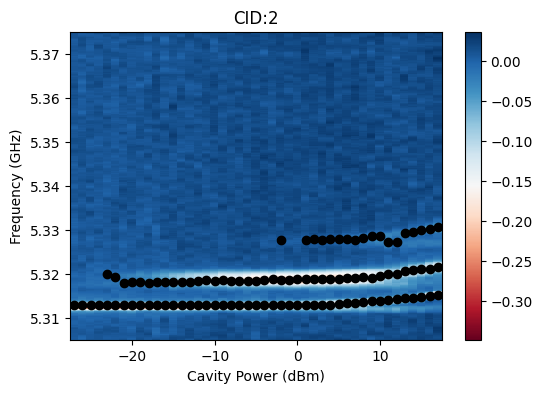

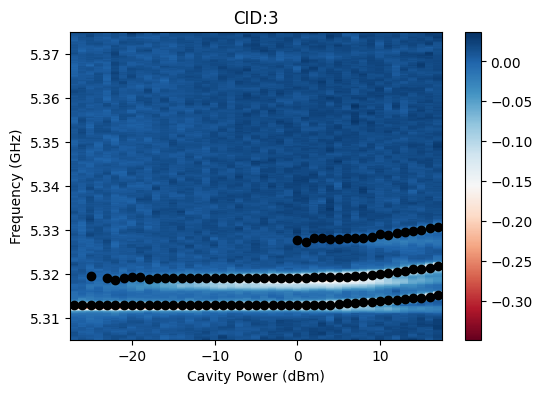

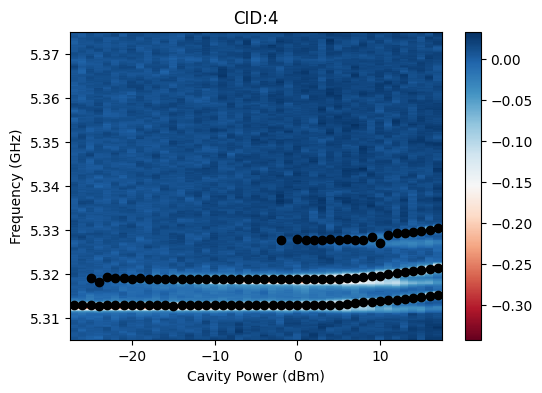

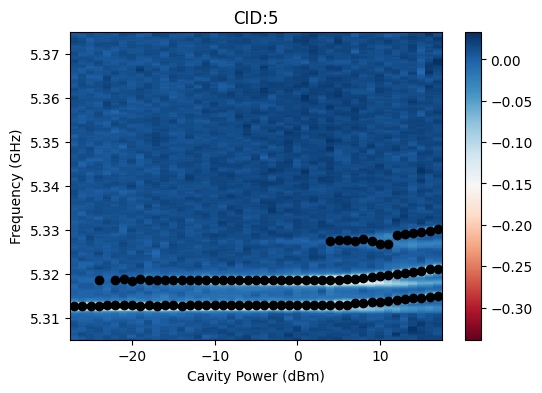

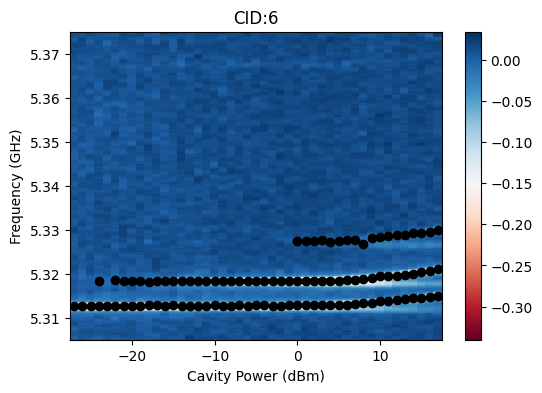

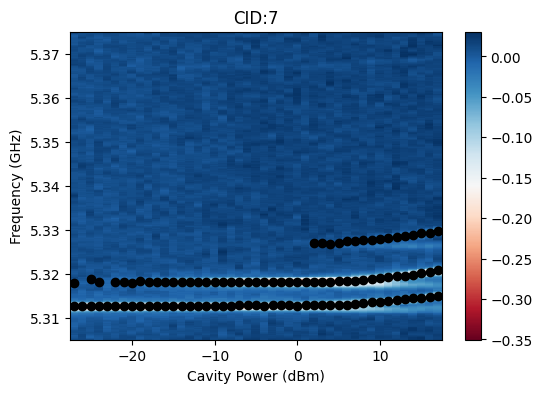

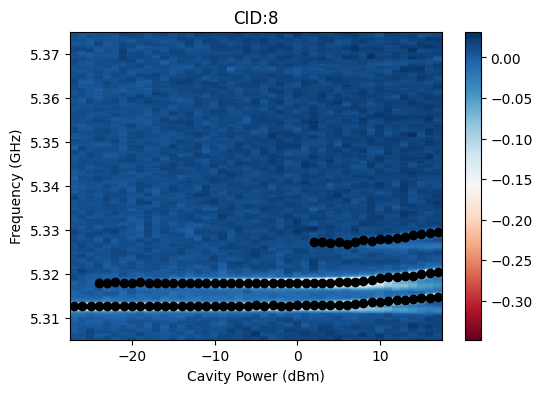

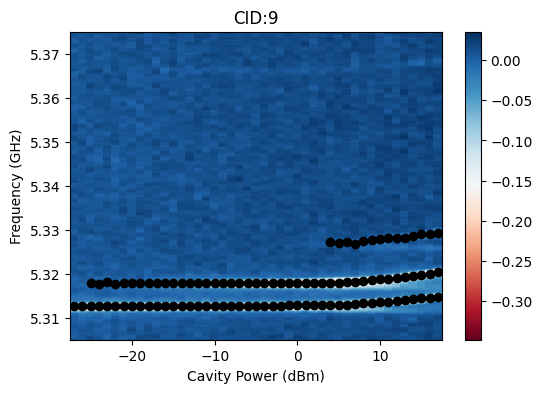

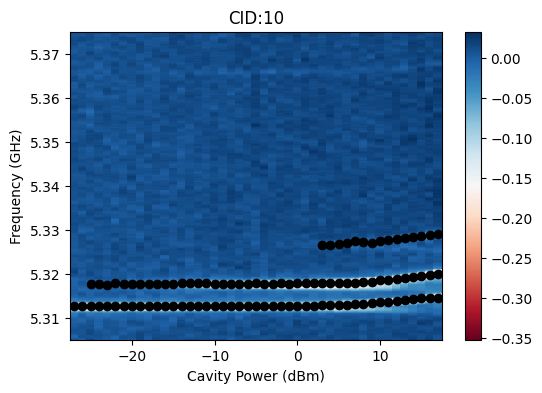

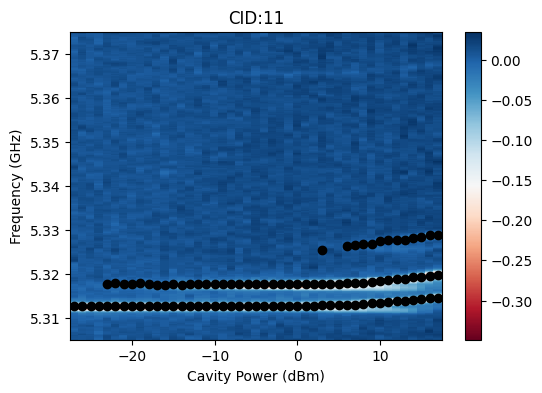

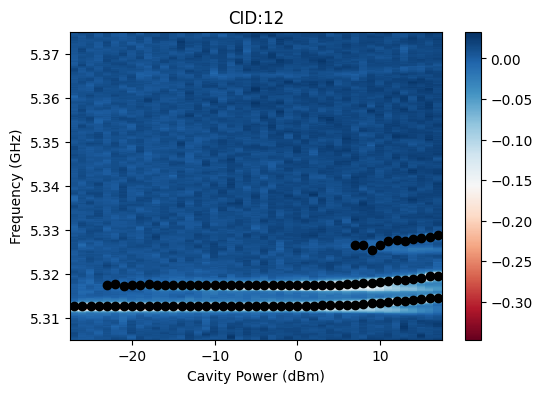

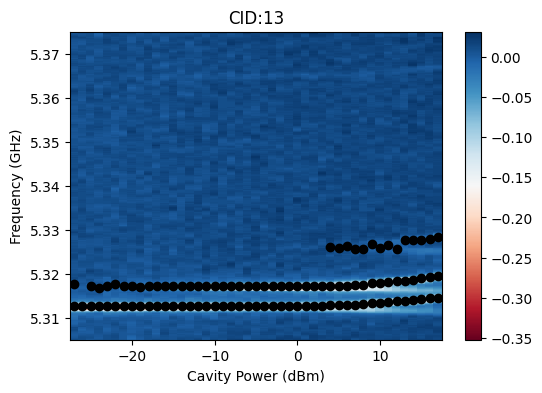

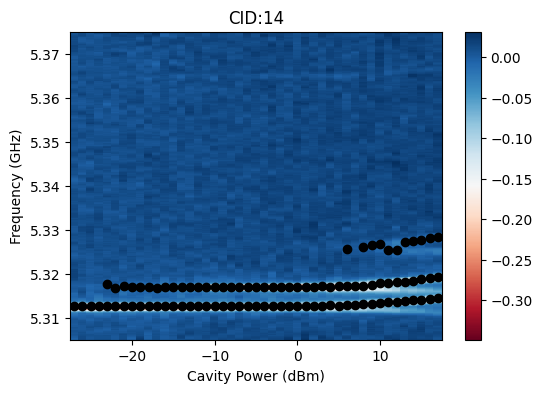

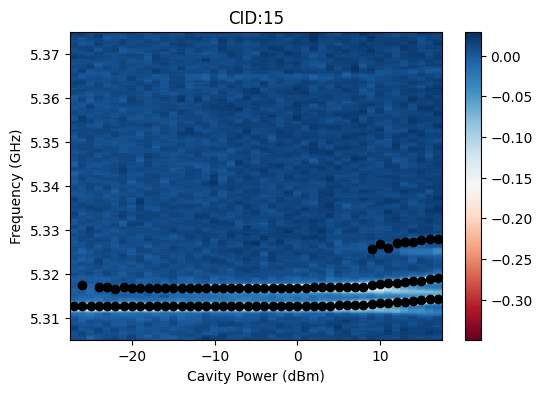

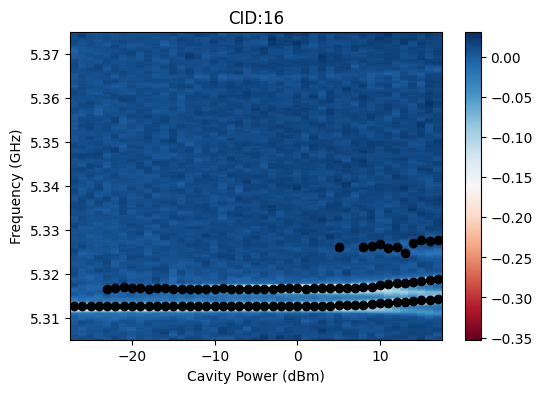

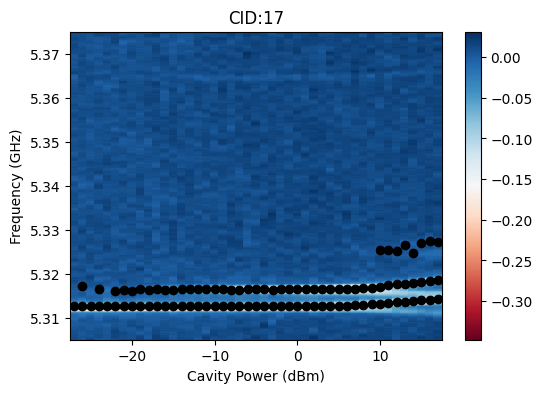

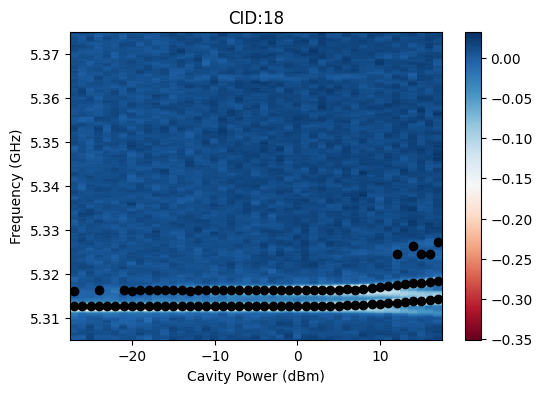

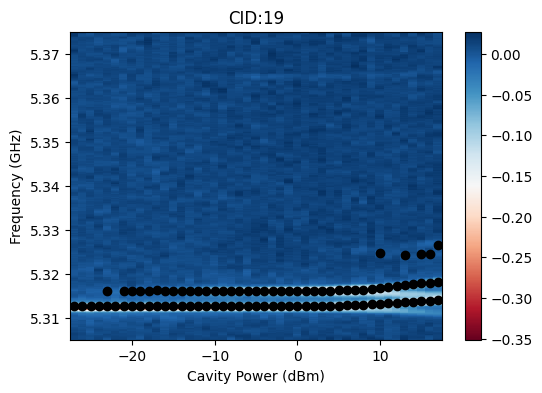

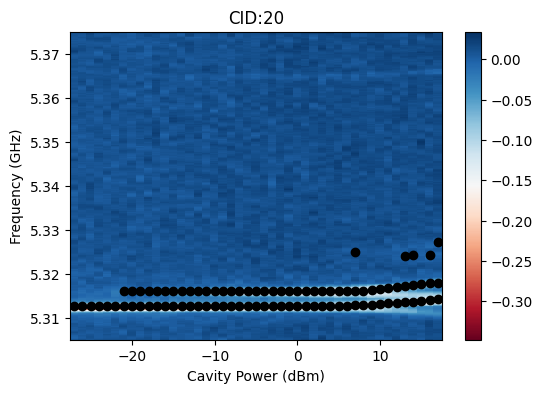

In [93]:
dataH = np.zeros([21, 45, 6])
fs_full = np.zeros([21, 45, 6])
for cid, counter in enumerate(idxs_lowP):
    if True:
        df = pd.read_csv(dpath + f'Q{4}-pns-power-{counter}.csv')

        freqs = np.unique(df['frequency'])
        buspows = np.unique(df['buspower'])
        phase = np.array(df['phase']).reshape([len(buspows), len(freqs)])
        phase = phase.transpose() - np.mean(phase[-50:, :], axis=1)
        phase = np.unwrap(phase)
        phase = scipy.signal.savgol_filter(phase, 11, 3, axis=0)

        fs = np.zeros([len(buspows), 6])
        hs = np.zeros([len(buspows), 6])
        for i in range(len(buspows)):
            y = -phase[:,i]
            if buspows[i] > cutoff[cid]:    
                limit = lim1[cid]
            if buspows[i] <= cutoff[cid]:    
                limit = lim2[cid]
            pks = scipy.signal.find_peaks(y, height=limit, width=width[cid], prominence=limit, distance=distance[cid])
            proms = np.zeros(len(pks[0]))
            for k in range(len(proms)):
                proms[k] = pks[1]['prominences'][k]
            counter = 0
            if len(pks[0]) > 1:
                if pks[1]['left_bases'][0] == pks[1]['left_bases'][1]:
                    pflips = [proms[0], proms[1]]
                    proms[0] = pflips[1]
                    proms[1] = pflips[0]
            for j in range(np.min([6, len(pks[0])])):
                if freqs[pks[0][j]] > 5.311e9 and freqs[pks[0][j]] < 5.350e9:
                    fs[i, counter] = freqs[pks[0][j]]
                    hs[i, counter] = proms[j]
                    counter += 1
            hs[i, :] = (hs[i, :] - np.min(hs[i, :]))/np.sum(hs[i, :])    
        
        dataH[cid, :, :] = hs
        fs_full[cid, :, :] = fs
        
        plt.figure(figsize=(6,4))
        plt.pcolor(buspows, freqs/1e9, phase, cmap='RdBu')
        plt.plot(buspows, fs/1e9, 'o', color='k')
        plt.colorbar()
        plt.ylim([np.min(freqs/1e9), None])
        plt.title(f'CID:{cid}')
        plt.ylabel('Frequency (GHz)')
        plt.xlabel('Cavity Power (dBm)')
        plt.show()

In [94]:
dataH.shape, fs_full.shape

((21, 45, 6), (21, 45, 6))

In [66]:
ncol = []
hscol = []
deltcol = []
fscol = []
powcol = []

In [67]:
for i, power in enumerate(buspows):
    for j, detune in enumerate(detuning):
        for n in range(4):
            ncol.append(n)
            hscol.append(dataH[j, i, n])
            deltcol.append(detune)
            fscol.append(fs_full[j, i, n])
            powcol.append(power)

In [68]:
df_dict = {
    'n': ncol,
    'pop': hscol,
    'detuning': deltcol,
    'freq': fscol,
    'power': powcol
}
df = pd.DataFrame(df_dict)

In [69]:
# df.to_csv("fit-results\\N3-photon-pops.csv")

In [95]:
g2s = np.zeros([len(detuning), len(buspows)])
for j in range(len(detuning)):
    for i in range(len(buspows)):
        if j < 25:
            g2s[j, i] = g2(dataH[j,i,:4])
        else:
            g2s[j, i] = g2(dataH[j,i,:3])

C:\Users\Instrument\AppData\Local\Temp\ipykernel_10324\4321067.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return num/den


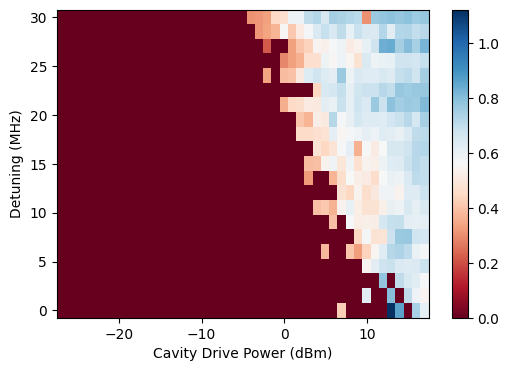

In [96]:
plt.figure(figsize=(6,4))
g2s[np.isnan(g2s)] = 0
plt.pcolor(buspows, detuning/1e6, g2s, cmap='RdBu')
plt.xlabel('Cavity Drive Power (dBm)')
plt.ylabel('Detuning (MHz)')
plt.colorbar()
plt.show()

In [97]:
g2_col = []
det_col = []
amp_col = []
for did, det in enumerate(detuning):
    for aid, amp in enumerate(buspows):
        g2_col.append(g2s[did, aid])
        det_col.append(det)
        amp_col.append(amp)
df_dict = {
    'g2': g2_col,
    'detuning': det_col,
    'power': amp_col
}
df = pd.DataFrame(df_dict)
# df.to_csv("fit-results\\g2-N3-exp.csv")